In [3]:
import os
os.chdir("../")

In [4]:
import wandb
import torch
import random
import time
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import optim
from tqdm import tqdm
from models.vt_resnet import vt_resnet18
from data_loaders.image_net import ImageNetDataset
from torch.utils.data import DataLoader, Subset
from typing import Any
from torchsummary import summary

In [5]:
%load_ext autoreload
%autoreload 2

# Utility Functions

In [6]:
def random_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

def store_params(content, name):
    f = open(f'params/{name}.pkl','wb')
    pickle.dump(content, f)
    f.close()

def load_params(name):
    fl = open(f'params/{name}.pkl', "rb")
    loaded = pickle.load(fl)
    return loaded

def store_model(model, name):
    torch.save(model.state_dict(), f'./trained_models/{name}.pth')
                                

# Data Preparation

In [7]:
project_name = 'vt_resnet18'
cores = 12
random_seed(8)
input_dim = 224
batch_size = 128
num_classes = 50
class_list = random.sample(range(1000), num_classes)

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((input_dim, input_dim)),
    #transforms.RandomResizedCrop(input_dim),
    transforms.RandomHorizontalFlip(),
    normalize
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((input_dim, input_dim)),
    normalize
])

train_dataset = ImageNetDataset(train=True, transform=train_transform, class_list=class_list)
valid_dataset = ImageNetDataset(train=False, transform=valid_transform, class_list=class_list)

In [9]:
[train_dataset.get_class_name(train_dataset.mapper[k]) for k in train_dataset.get_class_list()]

['balloon',
 'shovel',
 'sock',
 'ostrich',
 'boxer',
 'Blenheim_spaniel',
 'picket_fence',
 'Staffordshire_bullterrier',
 'Norfolk_terrier',
 'kuvasz',
 'bicycle-built-for-two',
 'wine_bottle',
 'rule',
 'echidna',
 'lorikeet',
 'sea_cucumber',
 'bloodhound',
 'green_lizard',
 'tree_frog',
 'American_chameleon',
 'great_grey_owl',
 'snorkel',
 'screw',
 'Pembroke',
 'fire_screen',
 'broom',
 'bee_eater',
 'squirrel_monkey',
 'spotted_salamander',
 'yawl',
 'crash_helmet',
 'Scottish_deerhound',
 'bannister',
 'sports_car',
 'binoculars',
 'drake',
 'boa_constrictor',
 'horizontal_bar',
 'fountain_pen',
 'junco',
 'artichoke',
 'Irish_water_spaniel',
 'patio',
 'ambulance',
 'proboscis_monkey',
 'drilling_platform',
 'hartebeest',
 'water_ouzel',
 'cicada',
 'pencil_sharpener']

/kuacc/users/nnayal17/.conda/envs/nazir_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


junco


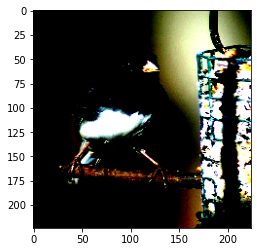

In [10]:
idx = 2000
print(train_dataset.get_class_name(train_dataset[idx][1]))
plt.imshow(train_dataset[idx][0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bee_eater


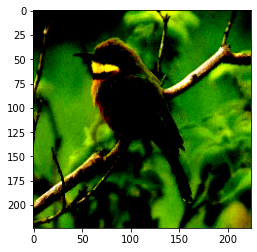

In [11]:
idx = 8
print(valid_dataset.get_class_name(valid_dataset[idx][1]))
plt.imshow(valid_dataset[idx][0].permute(1, 2, 0))

In [12]:
len(train_dataset), len(valid_dataset)

(64427, 2500)

In [13]:
total_valid_num = len(valid_dataset)
total_train_num = len(train_dataset)
valid_num = int(0.5 * total_valid_num)

valid_mask = list(range(valid_num))
test_mask = list(range(valid_num, total_valid_num))

valid_loader = DataLoader(Subset(valid_dataset, valid_mask), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Subset(valid_dataset, test_mask), batch_size=batch_size, shuffle=True)

small_train_mask = random.sample(range(total_train_num), 1200)
medium_train_mask = random.sample(range(total_train_num), 5000)
small_valid_mask = random.sample(range(total_valid_num), 200)

small_train_loader = DataLoader(Subset(train_dataset, list(small_train_mask)), batch_size=batch_size, 
                                shuffle=True, num_workers=2)
small_valid_loader = DataLoader(Subset(valid_dataset, list(small_valid_mask)), batch_size=batch_size, 
                                shuffle=True, num_workers=2)

medium_loader = DataLoader(Subset(train_dataset, list(medium_train_mask)), batch_size=batch_size, shuffle=True)

# Training

In [14]:
hyperparameters = {
    'epochs': 60,
    'pretrained': True,
    'freeze': 'no_freeze',
    'batch_size': 128,
    'learning_rate': 0.0002,
    'vt_channels': 512,
    'transformer_enc_layers': 2,
    'transformer_n_heads': 4,
    'transformer_fc_dims': 512,
    'transformer_dropout': 0.5,
    'tokens': 8,
    'token_dims': 512,
    'optimizer': 'adam',
    'weight_decay': 4e-5,
    'input_dim': input_dim,
    'num_classes': num_classes,
}

In [15]:
def evaluate(model: nn.Module, data_loader: Any, device: torch.device, comment: str = ""):
    
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0
    loss_history = []

    with torch.no_grad():
        for data, target in tqdm(data_loader):
            data = data.to(device)
            target = target.to(device)
            
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()
    
    avg_loss = total_loss / total_samples
    wandb.log({'valid_loss': avg_loss})
    
    accuracy = 100.0 * correct_samples / total_samples
    return accuracy

In [16]:
def train(model, optimizer, epochs, data_loader, test_loader, device):
    
    wandb.watch(model, log="all", log_freq=10)
    
    full_start = time.time()
    for i in range(epochs):
        
        model.train()
        model.to(device)
        print(f"Starting Epoch {i}")
        
        total_loss = 0
        epoch_time = time.time()
        num_batches = 0
        for j, (data, label) in enumerate(data_loader):
            
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, label)
            loss.backward()
            
            total_loss += loss.item()
            optimizer.step()
            num_batches += 1
            
            wandb.log({'batch_loss': loss.item()})
        print(f"Finished Epoch {i}")
        
        valid_accuracy = evaluate(model, test_loader, device)
        train_accuracy = evaluate(model, data_loader, device)
        
        print(f"Validation Accuracy: ", valid_accuracy)
        print(f"Training Accuracy: ", train_accuracy)
        
        wandb.log({
            'loss': total_loss / num_batches,
            'valid_accuracy': valid_accuracy,
            'train_accuracy': train_accuracy,
            'epoch_time_minutes': (time.time() - epoch_time) / 60
        })
    wandb.log({'full_run_time_minutes': (time.time() - full_start) / 60})
        

In [17]:
def train_model(hyperparameters):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    with wandb.init(project=project_name, config=hyperparameters):
       
        config = wandb.config
        
        model = vt_resnet18(
            pretrained=config.pretrained,
            freeze=config.freeze,
            tokens=config.tokens,
            token_channels=config.token_dims,
            input_dim=config.input_dim,
            vt_channels=config.vt_channels,
            transformer_enc_layers=config.transformer_enc_layers,
            transformer_heads=config.transformer_n_heads,
            transformer_fc_dim=config.transformer_fc_dims,
            transformer_dropout=config.transformer_dropout,
            num_classes=config.num_classes,
        )

        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=0.9)
           
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=cores)    
        
        train(model, optimizer, config.epochs, train_loader, valid_loader, device)

        test_accuracy = evaluate(model, test_loader, device)
        
        sample = train_dataset[0][0].reshape(1, 3, config.input_dim, config.input_dim)
        torch.onnx.export(model.to(torch.device('cpu')), sample, "vt_resnet18_50cls_20ep_1e4lr_4tk.onnx")
        
        wandb.log({'test_accuracy': test_accuracy})
    
    return model, test_accuracy

In [18]:
model, test_accuracy = train_model(hyperparameters)

cuda:0


AssertionError: 

In [ ]:
test_accuracy

In [ ]:
summary(model.to(torch.device('cuda:0')), (3, 224, 224))